In [1]:
import numpy as np
from numpy import asarray
from PIL import Image
import matplotlib.pyplot as plt

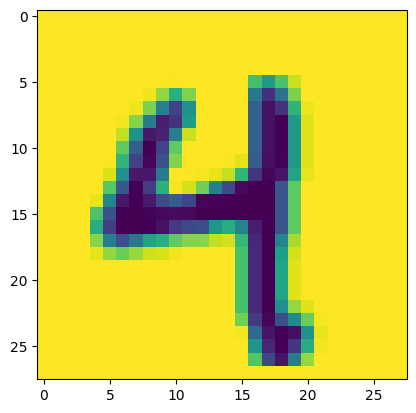

In [758]:
img = Image.open('four.png')
data = asarray(img)
plt.imshow(data)

In [710]:
def Conv2d(image: np.ndarray, kernel: np.ndarray, stride: int) -> np.ndarray:
    m, n = kernel.shape
    w, y, x = image.shape
    img = np.zeros((w, y+stride*2, x+stride*2))
    img[:, stride:y+stride, stride:x+stride] = image
    image = img
    new_image = np.zeros((w, y+stride*2-m+1,x+stride*2-n+1))
    for i in range(y+stride*2-m+1):
        for j in range(x+stride*2-n+1):
            new_image[:, i, j] = np.sum(image[:, i:i+m, j:j+n]*kernel, (1, 2))
    return new_image

In [204]:
def Diff2d(img: np.ndarray) -> np.ndarray:
    Scharr_y = np.array([[ 3,  10,  3],
                         [ 0,   0,  0],
                         [-3, -10, -3]])
    Scharr_x = np.array([[3,  0,  -3],
                         [10, 0, -10],
                         [3,  0,  -3]])
    img_x = Conv2d(img, Scharr_x, 2)
    img_y = Conv2d(img, Scharr_y, 2)
    return np.sqrt(img_x**2+img_y**2)

In [835]:
def Conv2d_diff(loss: np.ndarray, image: np.ndarray, kernel: np.ndarray, stride: int) -> np.ndarray:
    x = np.array([Conv2d(image[l][None,:,:], loss[l], stride) for l in range(loss.shape[0])])
    out = Conv2d(loss, kernel, stride)
    return x, out

In [716]:
def Linear(data: np.ndarray, weights: np.ndarray) -> np.ndarray:
    return data @ weights

In [734]:
def Linear_diff(loss: np.ndarray, data: np.ndarray, weights: np.ndarray) -> np.ndarray:
    return  data[:, :, None] * loss[:, None, :], loss @ np.linalg.pinv(weights)

In [720]:
def MSE(Y_p: np.ndarray, Y_e: np.ndarray) -> np.ndarray:
    return ((Y_p-Y_e)**2).sum(1)/Y_p.size

In [132]:
def MSE_diff(Y_p: np.ndarray, Y_e: np.ndarray) -> np.ndarray:
    return 2*(Y_p-Y_e)

In [357]:
def sigmoid(X):
    return 1 / (1 + np.exp(-X))
    
def anover_sigmoid(X):
    return np.exp(X) / (np.exp(X) + 1)
    
def stable_sigmoid(X):
    return sigmoid(X*(X >= 0))*(X >= 0) + anover_sigmoid(X*(X < 0))*(X < 0)

def Sigmoid(data: np.ndarray) -> np.ndarray:
    return stable_sigmoid(data)

In [463]:
def Sigmoid_diff(data: np.ndarray) -> np.ndarray:
    return Sigmoid(data)*(1-Sigmoid(data))

In [466]:
def Sigmoid_diff1(loss, data: np.ndarray) -> np.ndarray:
    return loss* data*(1-data)

In [42]:
def ReLU(data: np.ndarray) -> np.ndarray:
    return data*(data>0)

In [513]:
def ReLU_diff(data: np.ndarray) -> np.ndarray:
    return 1.*(data>0)
def ReLU_diff1(loss, data: np.ndarray) -> np.ndarray:
    return loss*(data>0)

In [850]:
kernel = np.random.random((7,7))
weights = np.random.random((28**2, 10))
Y_e = [0,0,0,0,1,0,0,0,0,0]
Y_e = np.array([Y_e for i in range(4)])

In [ ]:

data = np.array([data for i in range(4)])

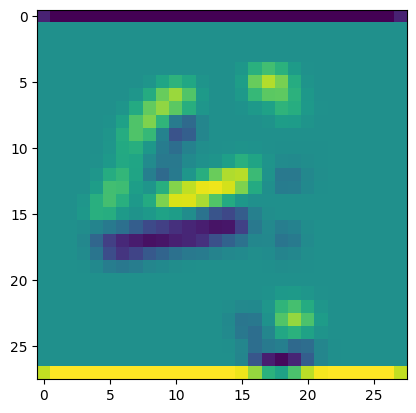

In [702]:
plt.imshow(Conv2d(data, Scharr_y, 1))

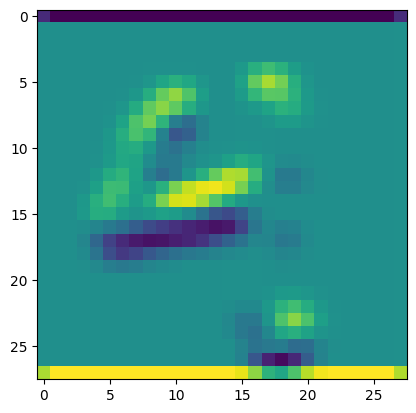

In [701]:
plt.imshow(Conv2d(data, kernel, 1))

In [854]:
l = np.zeros((500))
for i in range(500):
    x1 = Conv2d(data, kernel, 3)
    x2 = x1.reshape((4,28**2))
    x3 = Linear(x2, weights)
    x3max = np.abs(x3).max()
    x4 = Sigmoid(x3/x3max)
    x5 = MSE(x4, Y_e)
    l[i] = x5.sum()
    y1 = MSE_diff(x4, Y_e)
    y2 = Sigmoid_diff1(y1, x4)
    w, y3 = Linear_diff(y2, x2, weights)
    weights-=0.01*w.mean(0)
    y4 = y3.reshape((data.shape[0], 28, 28))
    k, _ = Conv2d_diff(y4, data, kernel, 3)
    kernel-=0.01*k.mean(0)[0]

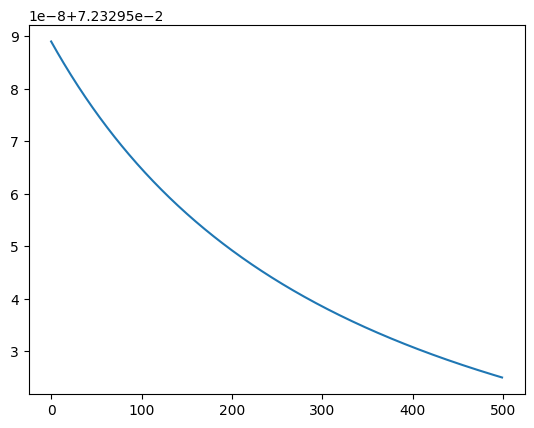

In [855]:
plt.plot(l);

In [747]:
x1 = Conv2d(data, kernel, 3)
x2 = x1.reshape((data.shape[0],28**2))
x3 = Linear(x2, weights)
x3max = np.abs(x3).max()
x4 = Sigmoid(x3/x3max)
x5 = MSE(x4, Y_e)
y1 = MSE_diff(x4, Y_e)
y2 = Sigmoid_diff1(y1, x3)
w, y3 = Linear_diff(y2, x2, weights)
y4 = y3.reshape((data.shape[0], 28, 28))
k, _ = Conv2d_diff(y4, data, kernel, 3)